# 1D CNN-Attention AutoEncoder - Prokaryotic Domain

## Imports

In [1]:
import matplotlib.pyplot as plt
import time
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
from tqdm.notebook import tqdm

import math
import torch.nn.functional as F

!pip install blosc
import blosc
import zstandard as zstd


#------- Parameters ----------

k =  1280 
P = 1
batch_size = 128
chunk_size = k

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.1 MB/s eta 0:00:00a 0:00:01


In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

## Training Loop

In [3]:
def train(model,
          train_loader,
          test_loader,
          training_iterations,
          evaluation_iterations,
          verbose=False,
          device=None):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    model.train()

    optimizer = optim.NAdam(model.parameters(), lr=0.0005)

    train_loss_vals = []
    eval_loss_vals = []

    train_losses = []
    eval_losses = []

    train_accuracies = []
    eval_accuracies = []

    pbar = tqdm(range(training_iterations))
    step_counter = 0

    while step_counter < training_iterations:
        for images, labels in train_loader:
            images = images.to(device)

            encoded, reconstruction = model(images)
            mse_loss = torch.mean((images - reconstruction) ** 2)

            train_loss_vals.append(mse_loss.item())

            optimizer.zero_grad()
            mse_loss.backward()
            optimizer.step()

            if step_counter % evaluation_iterations == 0:
                model.eval()
                eval_loss_batch = []

                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.to(device)
                        _, reconstruction = model(images)

                        loss_eval = torch.mean((images - reconstruction) ** 2)
                        eval_loss_batch.append(loss_eval.item())

                
                #------- Loss Calc ----------

                mean_train_loss = np.mean(train_loss_vals)
                mean_eval_loss = np.mean(eval_loss_batch)

                train_losses.append(mean_train_loss)
                eval_losses.append(mean_eval_loss)

                #------- Acc Calc ----------

                train_acc_batch = []
                with torch.no_grad():
                    for images, labels in train_loader:
                        images = images.to(device)
                        _, reconstruction = model(images)
                        train_pred_indices = torch.clamp(torch.round(reconstruction * 4.0), 0, 4).long()
                        train_true_indices = torch.clamp(torch.round(images * 4.0), 0, 4).long()
                        train_acc_batch.append((train_pred_indices == train_true_indices).float().mean().item())

                train_acc = np.mean(train_acc_batch) * 100
             
                eval_acc_batch = []
                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.to(device)
                        _, reconstruction = model(images)
                        eval_pred_indices = torch.clamp(torch.round(reconstruction * 4.0), 0, 4).long()
                        eval_true_indices = torch.clamp(torch.round(images * 4.0), 0, 4).long()
                        eval_acc_batch.append((eval_pred_indices == eval_true_indices).float().mean().item())

                eval_acc = np.mean(eval_acc_batch) * 100

                train_accuracies.append(train_acc)
                eval_accuracies.append(eval_acc)

                if verbose:
                    tqdm.write(
                        f"Step {step_counter}: "
                        f"Train Loss = {mean_train_loss:.6f}, "
                        f"Eval Loss = {mean_eval_loss:.6f}, "
                        f"Train Accuracy = {train_acc:.2f}%, "
                        f"Eval Accuracy = {eval_acc:.2f}%"
                    )


                train_loss_vals = []
                eval_loss_vals = []
                model.train()

            step_counter += 1
            pbar.update(1)

            if step_counter >= training_iterations:
                print("Completed Training:")
                break

    #------- Train Stats ----------

    print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
    print(f"Final Evaluation Loss: {eval_losses[-1]:.6f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.6f}%")
    print(f"Final Evaluation Accuracy: {eval_accuracies[-1]:.6f}%")

    return model, train_losses, eval_losses, train_accuracies, eval_accuracies


## Architecture

In [4]:
# --- Self-Attention Block  ---
class _SelfAttnBlock1D(nn.Module):
    def __init__(self, in_channels: int, embed_dim: int, num_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.proj_in = nn.Conv1d(in_channels, embed_dim, kernel_size=1)

        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=num_heads, batch_first=True, dropout=dropout
        )
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.ln2 = nn.LayerNorm(embed_dim)

    @staticmethod
    def _pos_enc(L: int, C: int, device):
        pe = torch.zeros(L, C, device=device)
        position = torch.arange(0, L, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, C, 2, device=device) * (-math.log(10000.0) / C))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, L = x.shape
        h = self.proj_in(x)        # (B, embed_dim, L)
        h = h.permute(0, 2, 1)     # (B, L, embed_dim)
        pe = self._pos_enc(L, h.shape[-1], x.device)
        h_pe = h + pe
        attn_out, _ = self.attn(h_pe, h_pe, h_pe, need_weights=False)
        h1 = self.ln1(h_pe + attn_out)
        ffn_out = self.ffn(h1)
        h2 = self.ln2(h1 + ffn_out)
        return h2.permute(0, 2, 1) # (B, embed_dim, L)

# --- Decoder with Self-Attention ---
class _DecoderWithSelfAttention(nn.Module):
    def __init__(self, latent_dim, embed_dim=32, num_heads=4):
        super().__init__()

        # L/16 → L/8
        self.up1 = nn.ConvTranspose1d(latent_dim, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.attn1 = _SelfAttnBlock1D(in_channels=128, embed_dim=128, num_heads=num_heads)

        # L/8 → L/4
        self.up2 = nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.attn2 = _SelfAttnBlock1D(in_channels=64, embed_dim=64, num_heads=num_heads)

        # L/4 → L/2
        self.up3 = nn.ConvTranspose1d(64, embed_dim, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm1d(embed_dim)
        self.attn3 = _SelfAttnBlock1D(in_channels=embed_dim, embed_dim=embed_dim, num_heads=num_heads)

        # L/2 → L (only upsampling)
        self.upsample_final = nn.ConvTranspose1d(embed_dim, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.final_act = nn.Sigmoid()

    def forward(self, z):
        x = F.relu(self.bn1(self.up1(z)))   # (B, 128, L/8)
        x = self.attn1(x)

        x = F.relu(self.bn2(self.up2(x)))   # (B, 64, L/4)
        x = self.attn2(x)

        x = F.relu(self.bn3(self.up3(x)))   # (B, embed_dim, L/2)
        x = self.attn3(x)

        # final upsample
        x = self.upsample_final(x)          # (B, 1, L)
        return self.final_act(x)

# --- Full Autoencoder  ---
class ConvolutionalAutoEncoder1D(nn.Module):

    def __init__(self, in_channels=1, latent_dim=4, input_length=1280,
                 attn_embed_dim=32, attn_heads=4):
        super().__init__()
        assert attn_embed_dim % attn_heads == 0, "attn_embed_dim must be divisible by attn_heads"

        self.latent_dim = latent_dim
        self.attn_embed_dim = attn_embed_dim

        # Encoder: L → L/16 with latent_dim channels
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, latent_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(),
        )

       
        self.bottleneck_proj_up   = nn.Conv1d(latent_dim, attn_embed_dim, kernel_size=1)
        self.encoder_attn         = _SelfAttnBlock1D(in_channels=attn_embed_dim,
                                                     embed_dim=attn_embed_dim,
                                                     num_heads=attn_heads)
        self.bottleneck_proj_down = nn.Conv1d(attn_embed_dim, latent_dim, kernel_size=1)

        # Latent → decoder channel expansion
        self.latent_to_decoder = nn.Conv1d(latent_dim, attn_embed_dim, kernel_size=1)

        # Decoder with attention at L/2
        self.decoder = _DecoderWithSelfAttention(latent_dim=attn_embed_dim,
                                                 embed_dim=attn_embed_dim,
                                                 num_heads=attn_heads)
    
    def forward_enc(self, x):
        z = self.encoder_conv(x)                 # (B, latent_dim, L/16)
        h = self.bottleneck_proj_up(z)           # (B, attn_embed_dim, L/16)
        h = self.encoder_attn(h)                 # (B, attn_embed_dim, L/16)
        z = self.bottleneck_proj_down(h)         # (B, latent_dim, L/16)  
        return z

    
    def forward_dec(self, z):
        z_proj = self.latent_to_decoder(z)       # (B, attn_embed_dim, L/16)
        return self.decoder(z_proj)              # (B, 1, L)


    def forward(self, x):
        encoded = self.forward_enc(x)
        decoded = self.forward_dec(encoded)
        return encoded, decoded


## Instantiation

In [5]:
conv1d_model = ConvolutionalAutoEncoder1D(in_channels=1, input_length=k, latent_dim=P,
                                          attn_embed_dim=32, attn_heads=4)

## Dataloaders and Model Training


=== Training on AeCa ===


  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0: Train Loss = 0.245521, Eval Loss = 0.231487, Train Accuracy = 16.81%, Eval Accuracy = 16.63%
Step 200: Train Loss = 0.080402, Eval Loss = 0.071429, Train Accuracy = 29.26%, Eval Accuracy = 29.35%
Step 400: Train Loss = 0.070980, Eval Loss = 0.071213, Train Accuracy = 28.86%, Eval Accuracy = 28.78%
Step 600: Train Loss = 0.069274, Eval Loss = 0.069785, Train Accuracy = 30.27%, Eval Accuracy = 30.16%
Step 800: Train Loss = 0.067833, Eval Loss = 0.068220, Train Accuracy = 31.97%, Eval Accuracy = 31.79%
Step 1000: Train Loss = 0.066954, Eval Loss = 0.067392, Train Accuracy = 32.31%, Eval Accuracy = 32.05%
Step 1200: Train Loss = 0.066119, Eval Loss = 0.066620, Train Accuracy = 32.25%, Eval Accuracy = 31.98%
Step 1400: Train Loss = 0.065393, Eval Loss = 0.066397, Train Accuracy = 32.57%, Eval Accuracy = 32.26%
Step 1600: Train Loss = 0.064700, Eval Loss = 0.066210, Train Accuracy = 33.30%, Eval Accuracy = 32.93%
Step 1800: Train Loss = 0.064221, Eval Loss = 0.065826, Train Accuracy 

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0: Train Loss = 0.081879, Eval Loss = 0.076577, Train Accuracy = 33.69%, Eval Accuracy = 33.74%
Step 200: Train Loss = 0.062153, Eval Loss = 0.061417, Train Accuracy = 35.99%, Eval Accuracy = 35.76%
Step 400: Train Loss = 0.060387, Eval Loss = 0.061899, Train Accuracy = 35.77%, Eval Accuracy = 35.56%
Step 600: Train Loss = 0.059770, Eval Loss = 0.060678, Train Accuracy = 36.38%, Eval Accuracy = 36.08%
Step 800: Train Loss = 0.059152, Eval Loss = 0.060577, Train Accuracy = 36.71%, Eval Accuracy = 36.22%
Step 1000: Train Loss = 0.058714, Eval Loss = 0.060765, Train Accuracy = 36.81%, Eval Accuracy = 36.26%
Step 1200: Train Loss = 0.058215, Eval Loss = 0.059985, Train Accuracy = 37.38%, Eval Accuracy = 36.72%
Step 1400: Train Loss = 0.057726, Eval Loss = 0.060045, Train Accuracy = 37.33%, Eval Accuracy = 36.53%
Step 1600: Train Loss = 0.057283, Eval Loss = 0.060098, Train Accuracy = 37.54%, Eval Accuracy = 36.74%
Step 1800: Train Loss = 0.056891, Eval Loss = 0.059734, Train Accuracy 

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0: Train Loss = 0.094065, Eval Loss = 0.071906, Train Accuracy = 32.06%, Eval Accuracy = 31.96%
Step 200: Train Loss = 0.064544, Eval Loss = 0.063259, Train Accuracy = 34.62%, Eval Accuracy = 34.53%
Step 400: Train Loss = 0.062583, Eval Loss = 0.063001, Train Accuracy = 34.81%, Eval Accuracy = 34.71%
Step 600: Train Loss = 0.062075, Eval Loss = 0.061952, Train Accuracy = 35.78%, Eval Accuracy = 35.67%
Step 800: Train Loss = 0.061693, Eval Loss = 0.062085, Train Accuracy = 35.65%, Eval Accuracy = 35.54%
Step 1000: Train Loss = 0.061496, Eval Loss = 0.061488, Train Accuracy = 35.99%, Eval Accuracy = 35.83%
Step 1200: Train Loss = 0.061247, Eval Loss = 0.061421, Train Accuracy = 36.13%, Eval Accuracy = 35.94%
Step 1400: Train Loss = 0.061033, Eval Loss = 0.060935, Train Accuracy = 36.49%, Eval Accuracy = 36.26%
Step 1600: Train Loss = 0.060817, Eval Loss = 0.062910, Train Accuracy = 35.33%, Eval Accuracy = 35.12%
Step 1800: Train Loss = 0.060653, Eval Loss = 0.060820, Train Accuracy 

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0: Train Loss = 0.083021, Eval Loss = 0.069875, Train Accuracy = 32.07%, Eval Accuracy = 31.98%
Step 200: Train Loss = 0.062945, Eval Loss = 0.062321, Train Accuracy = 34.06%, Eval Accuracy = 33.80%
Step 400: Train Loss = 0.061459, Eval Loss = 0.060966, Train Accuracy = 35.06%, Eval Accuracy = 34.59%
Step 600: Train Loss = 0.060694, Eval Loss = 0.062252, Train Accuracy = 34.64%, Eval Accuracy = 34.07%
Step 800: Train Loss = 0.060489, Eval Loss = 0.063575, Train Accuracy = 33.82%, Eval Accuracy = 33.23%
Step 1000: Train Loss = 0.059962, Eval Loss = 0.060702, Train Accuracy = 36.14%, Eval Accuracy = 35.28%
Step 1200: Train Loss = 0.059732, Eval Loss = 0.063898, Train Accuracy = 34.44%, Eval Accuracy = 33.64%
Step 1400: Train Loss = 0.059275, Eval Loss = 0.061174, Train Accuracy = 35.97%, Eval Accuracy = 34.90%
Step 1600: Train Loss = 0.058906, Eval Loss = 0.061234, Train Accuracy = 36.17%, Eval Accuracy = 35.01%
Step 1800: Train Loss = 0.058625, Eval Loss = 0.062283, Train Accuracy 

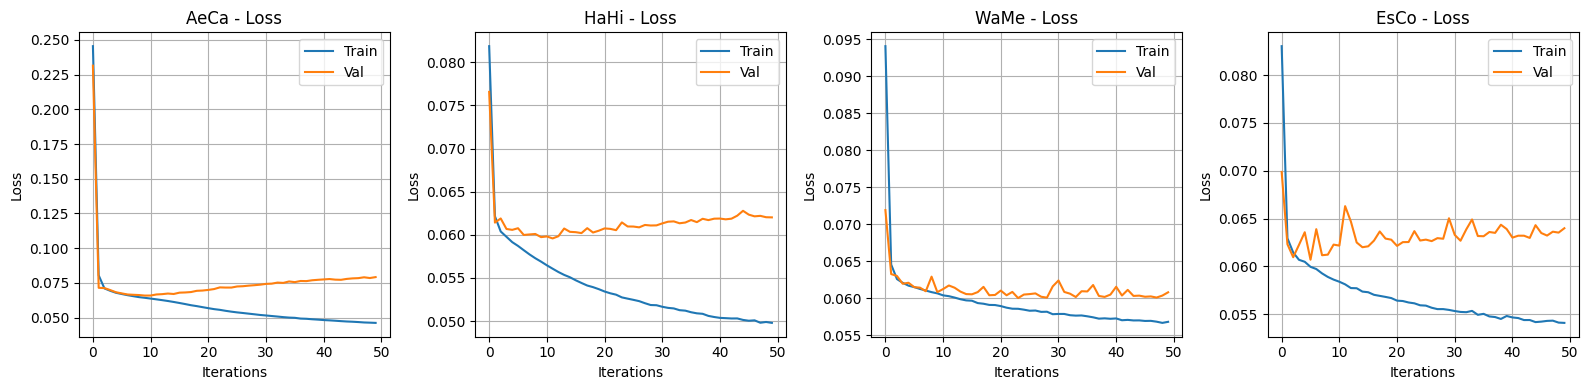

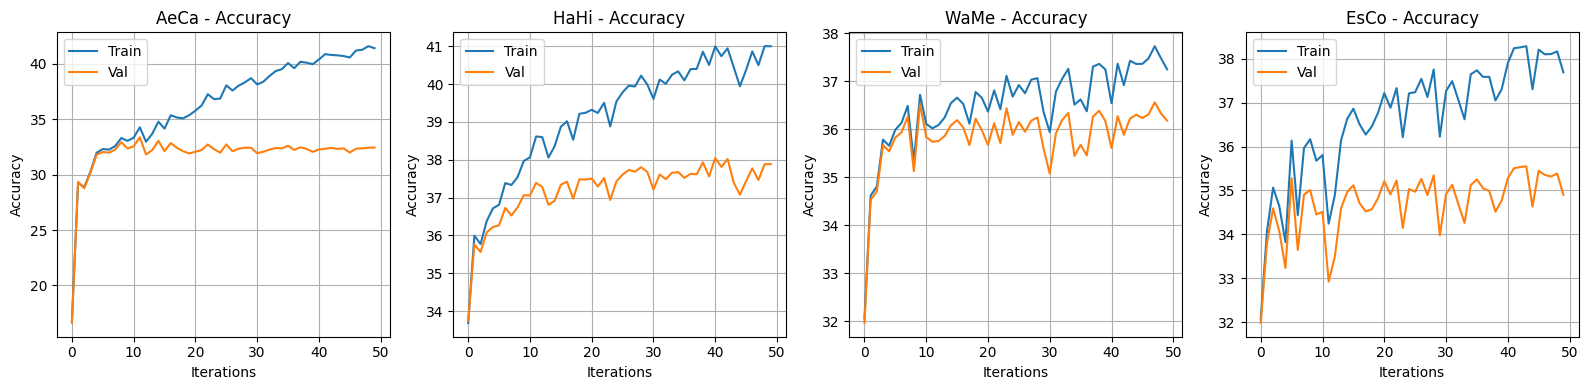

In [6]:
history_per_file = {}
file_times = {}

files_to_load = ['AeCa', 'HaHi', 'WaMe', 'EsCo']

data_dir = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"

for fname in files_to_load:
    print(f"\n=== Training on {fname} ===")
    
    start_time = time.time()   # ---- TIMER START ----

    # Load single file
    with open(os.path.join(data_dir, fname), 'r') as f:
        seq = f.read().strip()

    # Encode ATCG -> 0123
    content = seq.translate(str.maketrans('ATCG', '0123'))

    # Padding (if needed)
    remainder = len(content) % chunk_size
    if remainder != 0:
        pad_len = chunk_size - remainder
        content = content.ljust(len(content) + pad_len, '4')
    
    # Convert to array
    content_array = np.frombuffer(content.encode('ascii'), dtype=np.uint8) - ord('0')
    content_array = content_array.astype(np.float32) / 4.0

    reshaped = content_array.reshape(-1, chunk_size)
    tensor_data = torch.tensor(reshaped).unsqueeze(1)

    # Dummy labels
    dummy_labels = torch.zeros(len(tensor_data), dtype=torch.float32)

    # Dataset
    full_dataset = TensorDataset(tensor_data, dummy_labels)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # --- Train model on this file ---
    conv1d_model, train_losses, eval_losses, train_accs, eval_accs = train(
        conv1d_model,
        train_loader,
        test_loader,
        training_iterations=10000,
        evaluation_iterations=200,
        verbose=True
    )

    end_time = time.time()
    file_times[fname] = end_time - start_time
    history_per_file[fname] = {
    "train_loss": train_losses,
    "val_loss": eval_losses,
    "train_acc": train_accs,
    "val_acc": eval_accs
    }

print("\n\n===== PER-FILE TRAINING TIME =====")

for fname in files_to_load:
    print(f"\nFile: {fname}")
    print(f"  Training Time: {file_times[fname]:.2f} seconds")

print("\n===== LOSS AND ACCURACY =====")

# ===== LOSS curves side by side =====
plt.figure(figsize=(16, 4))

for i, fname in enumerate(files_to_load):
    hist = history_per_file[fname]
    plt.subplot(1, len(files_to_load), i + 1)
    plt.plot(hist["train_loss"], label="Train")
    plt.plot(hist["val_loss"], label="Val")
    plt.title(f"{fname} - Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# ===== ACCURACY curves side by side =====
plt.figure(figsize=(16, 4))

for i, fname in enumerate(files_to_load):
    hist = history_per_file[fname]
    plt.subplot(1, len(files_to_load), i + 1)
    plt.plot(hist["train_acc"], label="Train")
    plt.plot(hist["val_acc"], label="Val")
    plt.title(f"{fname} - Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Saving Model Weights

In [7]:
# Save model weights 
torch.save(conv1d_model.state_dict(), "/kaggle/working/autoencoder.pth")

## Model Testing


Processing: AeCa | Length: 1591049


  → Encoding & Decoding AeCa:   0%|          | 0/1244 [00:00<?, ?it/s]


Processing: AgPh | Length: 43970


  → Encoding & Decoding AgPh:   0%|          | 0/35 [00:00<?, ?it/s]


Processing: BuEb | Length: 18940


  → Encoding & Decoding BuEb:   0%|          | 0/15 [00:00<?, ?it/s]


Processing: EsCo | Length: 4641652


  → Encoding & Decoding EsCo:   0%|          | 0/3627 [00:00<?, ?it/s]


Processing: HaHi | Length: 3890005


  → Encoding & Decoding HaHi:   0%|          | 0/3040 [00:00<?, ?it/s]


Processing: HePy | Length: 1667825


  → Encoding & Decoding HePy:   0%|          | 0/1303 [00:00<?, ?it/s]


Processing: WaMe | Length: 9144432


  → Encoding & Decoding WaMe:   0%|          | 0/7145 [00:00<?, ?it/s]


Processing: YeMi | Length: 73689


  → Encoding & Decoding YeMi:   0%|          | 0/58 [00:00<?, ?it/s]


Saved evaluation_results.csv (TRAIN files only)
file  original_len  latent_size  accuracy (%)  compress_ratio
AeCa       1591049       398080         35.81            0.25
EsCo       4641652      1160640         37.83            0.25
HaHi       3890005       972800         37.57            0.25
WaMe       9144432      2286400         35.64            0.25

Saved evaluation_results_test.csv (TEST files only)
file  original_len  latent_size  accuracy (%)  compress_ratio
AgPh         43970        11200         36.75            0.25
BuEb         18940         4800         34.97            0.25
HePy       1667825       416960         36.72            0.25
YeMi         73689        18560         39.45            0.25


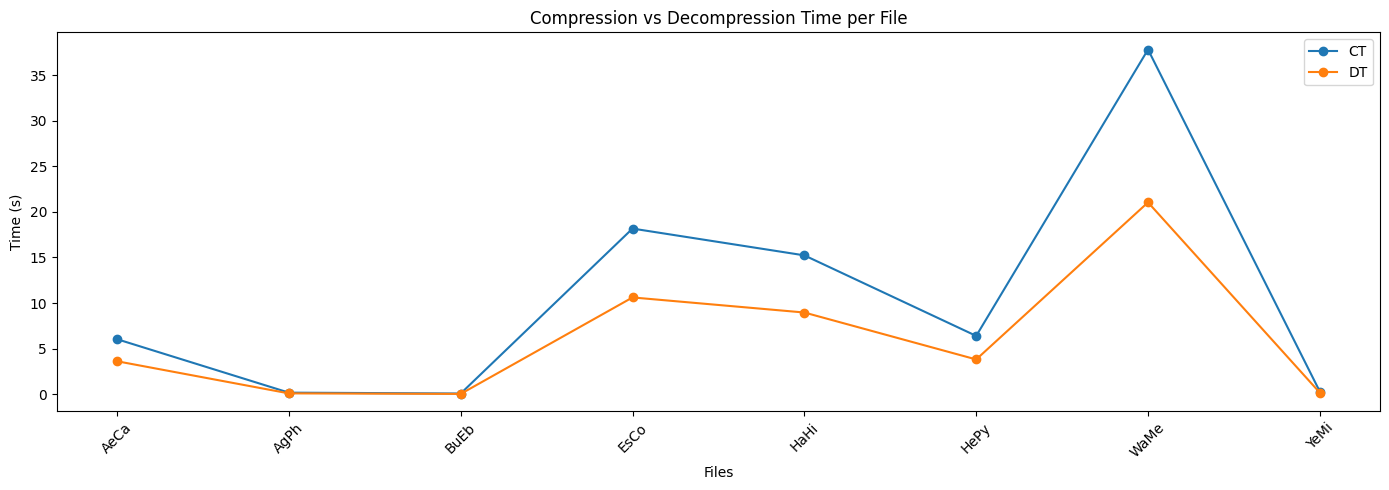

In [8]:
# === Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvolutionalAutoEncoder1D(in_channels=1, input_length=k, latent_dim=P)
model.load_state_dict(torch.load("/kaggle/working/autoencoder.pth", map_location=device))
# to load already trained model
# model.load_state_dict(torch.load("/kaggle/input/autoencode/pytorch/default/1/train_multiattention.pth", map_location=device)) 
model.to(device)
model.eval()

latent_dir = "/kaggle/working/latent"
os.makedirs(latent_dir, exist_ok=True)  

chunk_length = k
corpus_dir = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
vocab = ['A', 'T', 'C', 'G', 'N']

comp_times = []
decomp_times = []
file_labels = []

# === Utilities ===
def preprocess_sequence_1d(seq, chunk_length=k):
    seq = seq.translate(str.maketrans("ATCG", "0123"))
    remainder = len(seq) % chunk_length
    if remainder != 0:
        pad_len = chunk_length - remainder
        seq = seq.ljust(len(seq) + pad_len, '4')
    arr = np.frombuffer(seq.encode('ascii'), dtype=np.uint8) - ord("0")
    arr = arr / 4.0 
    arr = np.reshape(arr, (-1, chunk_length))
    return torch.tensor(arr, dtype=torch.float32).unsqueeze(1)  # (N_chunks, 1, k)

def decode_tensor_to_seq_1d(tensor, vocab):
    arr = tensor.squeeze().cpu().numpy()
    arr = np.clip(arr, 0, 1)
    indices = np.rint(arr * (len(vocab) - 1)).astype(int)
    indices = np.clip(indices, 0, len(vocab) - 1)
    return ''.join([vocab[i] for i in indices.flatten()])

def compute_accuracy(seq1, seq2):
    matches = sum(a == b for a, b in zip(seq1, seq2))
    return matches / len(seq1) * 100

# === Train & Test file lists ===
train_files = ['AeCa', 'HaHi', 'WaMe', 'EsCo']
test_files = [f for f in os.listdir(corpus_dir) if f not in train_files]

results = []

for filename in sorted(os.listdir(corpus_dir)):
    filepath = os.path.join(corpus_dir, filename)
    if not os.path.isfile(filepath):
        continue

    with open(filepath, 'r') as f:
        raw_seq = f.read().strip().upper()

    print(f"\nProcessing: {filename} | Length: {len(raw_seq)}")
    input_tensor = preprocess_sequence_1d(raw_seq, chunk_length).to(device)

    recon_seq = ""
    latent_total = 0
    n_chunks = len(input_tensor)

    with torch.no_grad():
        first_chunk = model.forward_enc(input_tensor[0].unsqueeze(0))
        latent_shape = first_chunk.shape[1:]
        latent_dtype = np.float32

        mmap_path = os.path.join(latent_dir, f"{filename}.dat")
        latent_mmap = np.memmap(mmap_path, dtype=latent_dtype, mode='w+', shape=(n_chunks, *latent_shape))

        comp_start = time.time()
        decomp_time_accum = 0.0

        for i in tqdm(range(n_chunks), desc=f"  → Encoding & Decoding {filename}"):
            chunk = input_tensor[i].unsqueeze(0)
    
            # ---- comp timing ----
            t1 = time.time()
            encoded = model.forward_enc(chunk)
            t2 = time.time()
            comp_time_step = (t2 - t1)

            # ---- decomp timing ----
            t3 = time.time()
            decoded = model.forward_dec(encoded)
            t4 = time.time()
            decomp_time_step = (t4 - t3)

            decomp_time_accum += decomp_time_step

            latent_np = encoded.cpu().numpy().astype(latent_dtype)[0]
            latent_mmap[i] = latent_np

            latent_total += encoded.numel()
            recon_seq += decode_tensor_to_seq_1d(decoded, vocab)

      

        latent_mmap.flush()
        final_latent = np.memmap(mmap_path, dtype=latent_dtype, mode='r', shape=(n_chunks, *latent_shape))
        np.save(os.path.join(latent_dir, f"{filename}.npy"), np.array(final_latent))
        os.remove(mmap_path)

    recon_seq = recon_seq[:len(raw_seq)]
    accuracy = compute_accuracy(raw_seq, recon_seq)

    comp_end = time.time()

    comp_times.append(comp_end - comp_start)
    decomp_times.append(decomp_time_accum)
    file_labels.append(filename)


    results.append({
        "file": filename,
        "original_len": len(raw_seq),
        "latent_size": latent_total * 4,
        "accuracy (%)": round(accuracy, 2),
        "compress_ratio": round(latent_total * 4 / len(raw_seq), 2)
    })

# === Save results ===
df = pd.DataFrame(results)

df_train = df[df["file"].isin(train_files)]
df_train.to_csv("/kaggle/working/evaluation_results.csv", index=False)
print("\nSaved evaluation_results.csv (TRAIN files only)")
print(df_train.to_string(index=False))


df_test = df[df["file"].isin(test_files)]
df_test.to_csv("/kaggle/working/evaluation_results_test.csv", index=False)
print("\nSaved evaluation_results_test.csv (TEST files only)")
print(df_test.to_string(index=False))

plt.figure(figsize=(14, 5))

plt.plot(file_labels, comp_times, marker='o', label="CT")
plt.plot(file_labels, decomp_times, marker='o', label="DT")

plt.xlabel("Files")
plt.ylabel("Time (s)")
plt.title("Compression vs Decompression Time per File")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Int8 Quantization 

In [9]:
quant_results = []
recon_int8_dir = "/kaggle/working/recon_int8"
os.makedirs(recon_int8_dir, exist_ok=True)

for _, row in df.iterrows():
    fname = row["file"]
    raw_path = os.path.join(corpus_dir, fname)
    with open(raw_path, "r") as f:
        raw_seq = f.read().strip().upper()

    # Load original latent float32 
    latent_fp32 = np.load(os.path.join(latent_dir, f"{fname}.npy"))  
    
    # Quantize float32 → int8
    min_val, max_val = latent_fp32.min(), latent_fp32.max()
    scale = (max_val - min_val) / 255 if max_val > min_val else 1.0
    latent_int8 = np.round((latent_fp32 - min_val) / scale).astype(np.uint8)

    # Save quantized latent as .npy 
    latent_int8_dir = "/kaggle/working/latent_int8"
    os.makedirs(latent_int8_dir, exist_ok=True)
    np.save(os.path.join(latent_int8_dir, f"{fname}_latent_int8.npy"), latent_int8)
    
    # Dequantize back to float32
    latent_fp32_recon = latent_int8.astype(np.float32) * scale + min_val
    latent_tensor = torch.tensor(latent_fp32_recon, dtype=torch.float32).to(device)

    # Decoding
    recon_seq = ""
    with torch.no_grad():
        for i in tqdm(range(latent_tensor.shape[0]), desc=f"  → Decoding int8 {fname}"):
            latent_chunk = latent_tensor[i].unsqueeze(0)
            decoded_chunk = model.forward_dec(latent_chunk)
            recon_seq += decode_tensor_to_seq_1d(decoded_chunk, vocab)

    recon_seq = recon_seq[:len(raw_seq)]

    # Save reconstructed sequence 
    if fname in train_files:
        subdir = os.path.join(recon_int8_dir, "train")
    else:
        subdir = os.path.join(recon_int8_dir, "test")
    os.makedirs(subdir, exist_ok=True)

    out_path = os.path.join(subdir, f"{fname}_recon_int8.txt")
    with open(out_path, "w") as f:
        f.write(recon_seq)

    # Accuracy and size
    accuracy = compute_accuracy(raw_seq, recon_seq)
    int8_size = latent_int8.nbytes
    int8_ratio = round(int8_size / len(raw_seq), 4)

    quant_results.append({
        "file": fname,
        "int8_size_bytes": int8_size,
        "int8_ratio": int8_ratio,
        "int8_acc (%)": round(accuracy, 2)
    })

quant_df = pd.DataFrame(quant_results)

# Update train CSV
df_train = pd.read_csv("/kaggle/working/evaluation_results.csv")
df_train = df_train.merge(quant_df, on="file", how="left")
df_train.to_csv("/kaggle/working/evaluation_results.csv", index=False)

# Update test CSV
df_test = pd.read_csv("/kaggle/working/evaluation_results_test.csv")
df_test = df_test.merge(quant_df, on="file", how="left")
df_test.to_csv("/kaggle/working/evaluation_results_test.csv", index=False)

print("\nAdded int8 quantization results to both CSVs")
print(df_train.to_string(index=False))
print(df_test.to_string(index=False))


  → Decoding int8 AeCa:   0%|          | 0/1244 [00:00<?, ?it/s]

  → Decoding int8 AgPh:   0%|          | 0/35 [00:00<?, ?it/s]

  → Decoding int8 BuEb:   0%|          | 0/15 [00:00<?, ?it/s]

  → Decoding int8 EsCo:   0%|          | 0/3627 [00:00<?, ?it/s]

  → Decoding int8 HaHi:   0%|          | 0/3040 [00:00<?, ?it/s]

  → Decoding int8 HePy:   0%|          | 0/1303 [00:00<?, ?it/s]

  → Decoding int8 WaMe:   0%|          | 0/7145 [00:00<?, ?it/s]

  → Decoding int8 YeMi:   0%|          | 0/58 [00:00<?, ?it/s]


Added int8 quantization results to both CSVs
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)
AeCa       1591049       398080         35.81            0.25            99520      0.0625         35.77
EsCo       4641652      1160640         37.83            0.25           290160      0.0625         37.78
HaHi       3890005       972800         37.57            0.25           243200      0.0625         37.52
WaMe       9144432      2286400         35.64            0.25           571600      0.0625         35.60
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)
AgPh         43970        11200         36.75            0.25             2800      0.0637         36.78
BuEb         18940         4800         34.97            0.25             1200      0.0634         34.88
HePy       1667825       416960         36.72            0.25           104240      0.0625         36.68
YeMi     

## Entropy Encoding (Zstd)

In [10]:
df_train = pd.read_csv("/kaggle/working/evaluation_results.csv")
df_test = pd.read_csv("/kaggle/working/evaluation_results_test.csv")

def compute_int8_blosc_stats(df_subset):
    int8_blosc_sizes = []
    int8_blosc_ratios = []

    for row in df_subset.itertuples(index=False):
        fname = row.file
        latent_fp32 = np.load(os.path.join(latent_dir, f"{fname}.npy"))

        # Re-quantize to int8
        min_val, max_val = latent_fp32.min(), latent_fp32.max()
        scale = (max_val - min_val) / 255 if max_val > min_val else 1.0
        latent_int8 = np.round((latent_fp32 - min_val) / scale).astype(np.uint8)

        # Compress with Blosc (zstd + clevel 9)
        compressed_bytes = blosc.compress(latent_int8.tobytes(), typesize=1, cname="zstd", clevel=9)
        compressed_size = len(compressed_bytes)
        ratio = round(compressed_size / row.original_len, 4)

        int8_blosc_sizes.append(compressed_size)
        int8_blosc_ratios.append(ratio)

    df_subset["int8_blosc_size"] = int8_blosc_sizes
    df_subset["int8_blosc_ratio"] = int8_blosc_ratios
    return df_subset

df_train = compute_int8_blosc_stats(df_train)
df_test = compute_int8_blosc_stats(df_test)

df_train.to_csv("/kaggle/working/evaluation_results.csv", index=False)
df_test.to_csv("/kaggle/working/evaluation_results_test.csv", index=False)

print("\nAdded int8 Blosc stats to both CSVs")
print("\n--- TRAIN ---")
print(df_train.to_string(index=False))
print("\n--- TEST ---")
print(df_test.to_string(index=False))



Added int8 Blosc stats to both CSVs

--- TRAIN ---
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)  int8_blosc_size  int8_blosc_ratio
AeCa       1591049       398080         35.81            0.25            99520      0.0625         35.77            89164            0.0560
EsCo       4641652      1160640         37.83            0.25           290160      0.0625         37.78           265502            0.0572
HaHi       3890005       972800         37.57            0.25           243200      0.0625         37.52           209634            0.0539
WaMe       9144432      2286400         35.64            0.25           571600      0.0625         35.60           528532            0.0578

--- TEST ---
file  original_len  latent_size  accuracy (%)  compress_ratio  int8_size_bytes  int8_ratio  int8_acc (%)  int8_blosc_size  int8_blosc_ratio
AgPh         43970        11200         36.75            0.25             2800      0.0637    

## Compute Residual (CSB Format)

In [11]:
# ------------ PATHS ------------
orig_dir = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
recon_root = "/kaggle/working/recon_int8"
csb_root = "/kaggle/working/CSB"

subfolders = ["train", "test"]


for sf in subfolders:
    os.makedirs(os.path.join(csb_root, sf), exist_ok=True)

# ------------ DNA base maps ------------
BASE2INT = {'A':0, 'T':1, 'C':2, 'G':3}
INT2BASE = {v:k for k,v in BASE2INT.items()}

# ------------ VARINT ENCODER ------------
def to_varint(x):
    out = []
    while True:
        byte = x & 0x7F
        x >>= 7
        if x:
            out.append(byte | 0x80)
        else:
            out.append(byte)
            break
    return out

# ------------ CSB ENCODER ------------
def encode_csb(original, reconstructed):
    mask = (original != reconstructed)
    pos = np.where(mask)[0]

    # delta encode
    if len(pos) == 0:
        deltas = []
    else:
        deltas = np.diff(np.insert(pos, 0, 0))

    pos_bytes = []
    for d in deltas:
        pos_bytes.extend(to_varint(int(d)))

    bases_int = np.array([BASE2INT[b] for b in original[pos]], dtype=np.uint8)

    return {
        "count": len(pos),
        "pos_bytes": bytes(pos_bytes),
        "base_bytes": bases_int.tobytes()
    }

# ------------ ZSTD COMPRESSOR ------------
zstd_compressor = zstd.ZstdCompressor(level=22) 


# ------------ PROCESS TRAIN + TEST ------------
for split in subfolders:
    recon_dir = os.path.join(recon_root, split)
    csb_out_dir = os.path.join(csb_root, split)

    files = sorted(os.listdir(recon_dir))

    print(f"\n=== Processing {split.upper()} ({len(files)} files) ===")

    for fname in files:

        # Extract base name
        if fname.endswith("_recon_int8.txt"):
            base = fname.replace("_recon_int8.txt", "")
        else:
            print(f"Skipping {fname}: unexpected filename")
            continue

        orig_path = os.path.join(orig_dir, base)
        recon_path = os.path.join(recon_dir, fname)

        if not os.path.exists(orig_path):
            print(f"Skipping {fname}: original not found at {orig_path}")
            continue

        # Load sequences
        with open(orig_path, "r") as f:
            original = f.read().strip()

        with open(recon_path, "r") as f:
            reconstructed = f.read().strip()

        # Convert to arrays
        original_arr = np.array(list(original), dtype='<U1')
        recon_arr = np.array(list(reconstructed), dtype='<U1')

        csb = encode_csb(original_arr, recon_arr)

        # ---------------- SAVE RAW CSB ----------------
        csb_path = os.path.join(csb_out_dir, base + ".csb")

        with open(csb_path, "wb") as f:
            f.write(np.uint32(csb["count"]).tobytes())
            f.write(csb["pos_bytes"])
            f.write(csb["base_bytes"])

        # ---------------- SAVE ZSTD COMPRESSED VERSION ----------------
        zstd_path = csb_path + ".zst"

        with open(csb_path, "rb") as f:
            raw_data = f.read()

        compressed = zstd_compressor.compress(raw_data)

        with open(zstd_path, "wb") as f:
            f.write(compressed)

        print(f"Saved CSB: {csb_path} | mismatches={csb['count']} | ZSTD={len(compressed)} bytes")

print("\n All CSB + ZSTD files generated successfully!")


=== Processing TRAIN (4 files) ===
Saved CSB: /kaggle/working/CSB/train/AeCa.csb | mismatches=1022005 | ZSTD=480183 bytes
Saved CSB: /kaggle/working/CSB/train/EsCo.csb | mismatches=2888179 | ZSTD=1380020 bytes
Saved CSB: /kaggle/working/CSB/train/HaHi.csb | mismatches=2430648 | ZSTD=1146923 bytes
Saved CSB: /kaggle/working/CSB/train/WaMe.csb | mismatches=5889276 | ZSTD=2741807 bytes

=== Processing TEST (4 files) ===
Saved CSB: /kaggle/working/CSB/test/AgPh.csb | mismatches=27796 | ZSTD=14386 bytes
Saved CSB: /kaggle/working/CSB/test/BuEb.csb | mismatches=12334 | ZSTD=6391 bytes
Saved CSB: /kaggle/working/CSB/test/HePy.csb | mismatches=1056117 | ZSTD=499258 bytes
Saved CSB: /kaggle/working/CSB/test/YeMi.csb | mismatches=44673 | ZSTD=22725 bytes

 All CSB + ZSTD files generated successfully!


## Final Compressed Size


 Overall compression ratios added to CSVs

--- TRAIN RESULTS PREVIEW ---
file  orig_size_bytes  latent_int8_bytes  residual_bytes  total_output_bytes  overall_compression_ratio
AeCa          1591049              99648          480183              579831                   0.364433
EsCo          4641652             290288         1380020             1670308                   0.359852
HaHi          3890005             243328         1146923             1390251                   0.357391
WaMe          9144432             571728         2741807             3313535                   0.362355

--- TEST RESULTS PREVIEW ---
file  orig_size_bytes  latent_int8_bytes  residual_bytes  total_output_bytes  overall_compression_ratio
AgPh            43970               2928           14386               17314                   0.393768
BuEb            18940               1328            6391                7719                   0.407550
HePy          1667825             104368          499258        

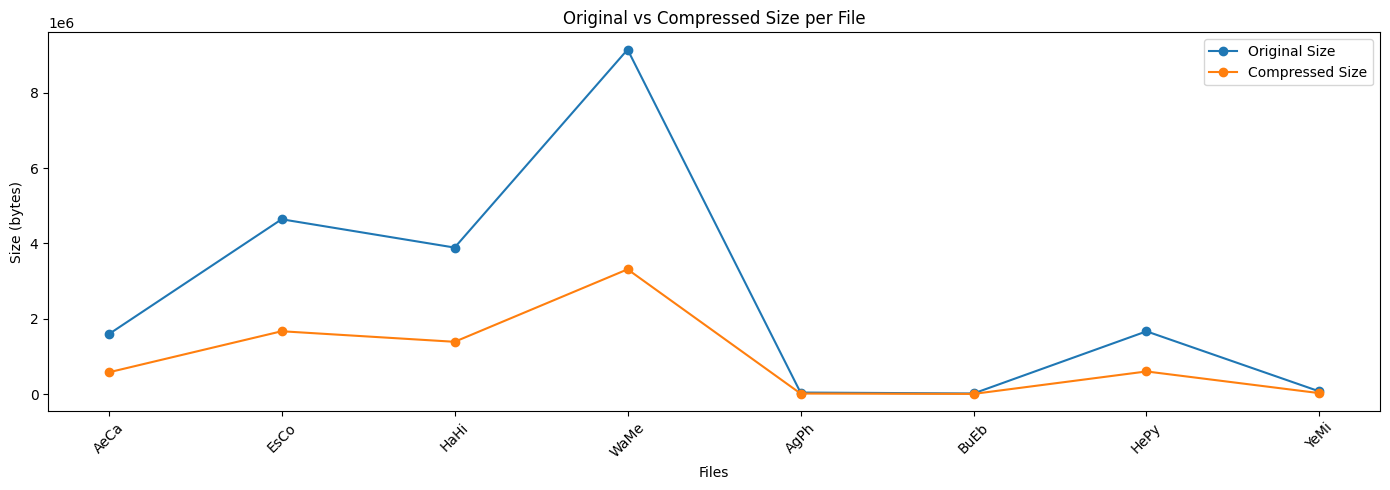

In [12]:
# -------- Paths ----------
orig_dir        = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
latent_int8_dir = "/kaggle/working/latent_int8"
csb_root        = "/kaggle/working/CSB"
train_csv = "/kaggle/working/evaluation_results.csv"
test_csv  = "/kaggle/working/evaluation_results_test.csv"

USE_ZSTD = True  

subfolders = ["train", "test"]

def get_file_size(path):
    return os.path.getsize(path) if os.path.exists(path) else 0


def compute_ratios(df, split):
    results = []

    csb_dir = os.path.join(csb_root, split)

    for _, row in df.iterrows():
        fname = row["file"]

        # Original file size (input)
        orig_path = os.path.join(orig_dir, fname)
        orig_size = get_file_size(orig_path)

        # Latent int8 size (.npy)
        latent_path = os.path.join(latent_int8_dir, f"{fname}_latent_int8.npy")
        latent_size = get_file_size(latent_path)

        # CSB size
        if USE_ZSTD:
            csb_path = os.path.join(csb_dir, f"{fname}.csb.zst")
        else:
            csb_path = os.path.join(csb_dir, f"{fname}.csb")

        csb_size = get_file_size(csb_path)

        # Output size = latent + CSB
        output_size = latent_size + csb_size
        if orig_size > 0:
            comp_ratio = round(output_size / orig_size, 6)
        else:
            comp_ratio = 0.0

        results.append({
            "file": fname,
            "orig_size_bytes": orig_size,
            "latent_int8_bytes": latent_size,
            "residual_bytes": csb_size,
            "total_output_bytes": output_size,
            "overall_compression_ratio": comp_ratio
        })

    return pd.DataFrame(results)


# -------- Process TRAIN ----------
df_train = pd.read_csv(train_csv)
train_stats = compute_ratios(df_train, "train")

df_train["file"] = df_train["file"].astype(str).str.strip()
train_stats["file"] = train_stats["file"].astype(str).str.strip()

df_train = df_train.merge(train_stats, on="file", how="left")
df_train.to_csv(train_csv, index=False)

# -------- Process TEST ----------
df_test = pd.read_csv(test_csv)
test_stats = compute_ratios(df_test, "test")

df_test["file"] = df_test["file"].astype(str).str.strip()
test_stats["file"] = test_stats["file"].astype(str).str.strip()

df_test = df_test.merge(test_stats, on="file", how="left")

df_test.to_csv(test_csv, index=False)

print("\n Overall compression ratios added to CSVs")

print("\n--- TRAIN RESULTS PREVIEW ---")
cols = [
    "file",
    "orig_size_bytes",
    "latent_int8_bytes",
    "residual_bytes",
    "total_output_bytes",
    "overall_compression_ratio"
]

print(df_train[[c for c in cols if c in df_train.columns]].to_string(index=False))

print("\n--- TEST RESULTS PREVIEW ---")
cols = [
    "file",
    "orig_size_bytes",
    "latent_int8_bytes",
    "residual_bytes",
    "total_output_bytes",
    "overall_compression_ratio"
]
print(df_test[[c for c in cols if c in df_test.columns]].to_string(index=False))


# ===== Curve: Original vs Compressed Size =====
plt.figure(figsize=(14, 5))

plot_df = pd.concat([df_train, df_test], ignore_index=True)

x = plot_df["file"]
y_orig = plot_df["orig_size_bytes"]
y_comp = plot_df["total_output_bytes"]

plt.plot(x, y_orig, marker='o', label="Original Size")
plt.plot(x, y_comp, marker='o', label="Compressed Size")

plt.xlabel("Files")
plt.ylabel("Size (bytes)")
plt.title("Original vs Compressed Size per File")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Verification After Adding Residual

In [13]:
import os
import numpy as np
import pandas as pd
import zstandard as zstd

orig_root  = "/kaggle/input/dnacorpus/DNACorpus/Prokaryotic"
recon_root = "/kaggle/working/recon_int8"
csb_root   = "/kaggle/working/CSB"

BASE2INT = {'A':0, 'T':1, 'C':2, 'G':3}
INT2BASE = {v:k for k,v in BASE2INT.items()}

splits = ["train", "test"]

# ------------ ZSTD decompress ------------
def decompress_zst(path):
    dctx = zstd.ZstdDecompressor()
    with open(path, "rb") as f:
        return dctx.decompress(f.read())

def read_varints(byte_arr, count):
    result = []
    idx = 0
    for _ in range(count):
        shift = 0
        value = 0
        while True:
            b = byte_arr[idx]
            idx += 1
            value |= (b & 0x7F) << shift
            if not (b & 0x80):
                break
            shift += 7
        result.append(value)
    return result, idx

# ------------ decode CSB file ------------
def decode_csb(raw_bytes):
    count = np.frombuffer(raw_bytes[:4], dtype=np.uint32)[0]
    pos_diffs_bytes = raw_bytes[4:]

    if count == 0:
        return [], []  

    pos_diffs, consumed = read_varints(pos_diffs_bytes, count)

    base_vals = np.frombuffer(pos_diffs_bytes[consumed:], dtype=np.uint8)

    positions = []
    acc = 0
    for d in pos_diffs:
        acc += d
        positions.append(acc)

    return positions, base_vals

results = []

for split in splits:
    recon_dir = os.path.join(recon_root, split)
    csb_dir   = os.path.join(csb_root, split)

    print(f"\n=== Processing {split.upper()} ===")
    for fname in sorted(os.listdir(recon_dir)):
        if not fname.endswith(".txt"):
            continue

        base = fname.replace("_recon_int8.txt","")
        recon_path = os.path.join(recon_dir, fname)
        csb_path   = os.path.join(csb_dir, base + ".csb.zst")
        orig_path  = os.path.join(orig_root, base)

        if not os.path.exists(csb_path) or not os.path.exists(orig_path):
            print(f"Missing for {base}")
            continue

        # load sequences
        with open(recon_path) as f:
            recon = list(f.read().strip())
        with open(orig_path) as f:
            orig = list(f.read().strip())

        L = min(len(recon), len(orig))
        recon = recon[:L]
        orig = orig[:L]

        # decode CSB
        raw = decompress_zst(csb_path)
        positions, base_vals = decode_csb(raw)

        # reconstruct final
        final = recon.copy()
        for i, p in enumerate(positions):
            if p < L:
                final[p] = INT2BASE[int(base_vals[i])]

        # compute accuracy
        final = np.array(final)
        orig  = np.array(orig)
        mismatches = np.sum(final != orig)
        accuracy = 100.0 * (1 - mismatches / L)

        print(f"{base}: L={L} mism={mismatches} acc={accuracy:.6f}% stored_diff={len(positions)}")

        results.append((split, base, L, mismatches, accuracy))


df = pd.DataFrame(results, columns=["Split","File","Length","Mismatches","Accuracy"])
print("\n=========== FINAL ACCURACY ===========")
print(df.to_string(index=False))

csv_path = "/kaggle/working/final_reconstruction_accuracy.csv"
df.to_csv(csv_path, index=False)
print(f"\nSaved summary CSV -> {csv_path}")



=== Processing TRAIN ===
AeCa: L=1591049 mism=0 acc=100.000000% stored_diff=1022005
EsCo: L=4641652 mism=0 acc=100.000000% stored_diff=2888179
HaHi: L=3890005 mism=0 acc=100.000000% stored_diff=2430648
WaMe: L=9144432 mism=0 acc=100.000000% stored_diff=5889276

=== Processing TEST ===
AgPh: L=43970 mism=0 acc=100.000000% stored_diff=27796
BuEb: L=18940 mism=0 acc=100.000000% stored_diff=12334
HePy: L=1667825 mism=0 acc=100.000000% stored_diff=1056117
YeMi: L=73689 mism=0 acc=100.000000% stored_diff=44673

=========== FINAL ACCURACY ===========
Split File  Length  Mismatches  Accuracy
train AeCa 1591049           0     100.0
train EsCo 4641652           0     100.0
train HaHi 3890005           0     100.0
train WaMe 9144432           0     100.0
 test AgPh   43970           0     100.0
 test BuEb   18940           0     100.0
 test HePy 1667825           0     100.0
 test YeMi   73689           0     100.0

Saved summary CSV -> /kaggle/working/final_reconstruction_accuracy.csv
